<h1><center>Case Studies Assignment 1</center></h1>
<h2><center> Object Detection and Classification</center></h2>
<h3><center> Khadija Sitabkhan - 20236001</center></h3>

The Object of the code below is to understand and implement the following concepts:
1. Image detection using Tiny-YOLO Model
2. Image classification by understanding the concepts of Transfer learning using keras sequential model

In [1]:
import cv2
import numpy as np
import pandas as pd
import time
import sys
import PIL.Image as Image
import os
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from sklearn.model_selection import train_test_split

The below lines are commented as they do not need to be run each time. 
They are using to install the bing-image downloader library which is used to download images for training our Keras Sequential Model

In [2]:
# !pip install bing-image-downloader  #[2]
# from bing_image_downloader import downloader
# query_string="sedan"
# downloader.download(query_string, limit=500,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)

In [3]:
# query_string="suv"
# downloader.download(query_string, limit=500,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)

The global dictionary is created which will store the classes of detection. 
<br> Since we have only two classes we can have 0 assigned to sedan and 1 assigned to SUV type cars. 
<br> Softmax activation function is not used since we have just two classes.

In [4]:
car_label_dictionary = {
    'sedan' : 0,
    'suv' : 1
  }

**object_classification** class is used to train the Keras sequential model for detecting the sedan or SUV cars. 
1. Keras sequential is one of the many algorithms present in tensorflow keras. It is used to implement a simple feed forward neural network
2. We load the images from 2 seperate directories, one being sedan and the other being SUV
3. These images are stored in the form of numpy arrays containing integers. 
4. They are then passed to the sequential model for training 
5. The weights then calculated using the training set are used to evaluate the model on the test data. 
6. an Accuracy of 98.95% is obtained on the test data.
7. We flatten the images first into one numpy array
8. Two hidden layers are implemented first one of 128 nodes and the second one having 64 nodes. 

In [5]:
class object_classification: ## [3] Transfer learning

    def __init__ (self):
        self.IMAGE_SHAPE=(224,224)
        self.classifier = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=self.IMAGE_SHAPE+(3,))])

    def TrainClassifier(self):
        data_dir=pathlib.Path(".\\dataset")
        #list(data_dir.glob('*/*.jp*g'))[:5]
        image_count = len(list(data_dir.glob('*/*g')))
        print("Image count in Data set is ",image_count)
        sedan = list(data_dir.glob('sedan/*'))
        #sedan[:5]
        suv = list(data_dir.glob('suv/*'))
        #suv[:5]
        car_dictionary = {
            'suv' : list(data_dir.glob("suv/*")),
            'sedan': list(data_dir.glob("sedan/*"))
        }
        car_label_dictionary = {
            'sedan' : 0,
            'suv' : 1
        }
        X, y = [], []

        for car_name, images in car_dictionary.items():
            for image in images:
                img = cv2.imread(str(image))
                resized_img = cv2.resize(img,self.IMAGE_SHAPE)
                X.append(resized_img)
                y.append(car_label_dictionary[car_name])
        X=np.array(X)
        y=np.array(y)
        X_train,X_test , y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.3)
        X_train,X_val , y_train, y_val = train_test_split(X_train,y_train,random_state=0,test_size=0.3)
        X_val_scaled = X_val/255
        X_train_scaled= X_train/255
        X_test_scaled = X_test/255
        #Getting the feature extractor model
        feature_extracter_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

        pretrained_model_without_top_layer = hub.KerasLayer(
            feature_extracter_model, input_shape=(224, 224, 3), trainable=False)
        num_of_cars = 2
        self.model = tf.keras.Sequential([
            pretrained_model_without_top_layer,
            layers.Flatten(),    
            layers.Dense(128, activation='relu'), 
#             layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_of_cars)
        ])
        self.model.summary() #This prints the summary as to how many trainable parameters are present from the total params
        self.model.compile(optimizer="adam", # Adam optimiser is used
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['acc'])
        self.model.fit(X_train_scaled, y_train, epochs=10)
        print("Evaluating on Validation set")
        self.Evaluate(self.model,X_val_scaled,y_val)
        return X_test_scaled,y_test,self.model
    
    def Evaluate(self, model,X,y):# This function is used to evaluate the Keras based on the test data
        print("evaluation Results")
        model.evaluate(X,y)
        
    def Predict(self, model,X):
#This function is used to predict the class of the cars detected in the video
        predicted = model.predict(X[np.newaxis, ...])
        predicted = np.argmax(predicted, axis=1)
        return ([k for k, v in car_label_dictionary.items() if v == predicted])

**object_detection** class is used to run the tiny yolo model. 
1. The config file and weights file for the yiny yolo are downloaded and placed un the same directory.
2. The threshold values are set for the confidence. If it confidence value is above the threshold only then the object will display a bounding box around the object in 
3. coco.names is used to provide the names of all the classes that can be detected using the tiny YOLO model. 
4. we then call tiny yolo on the frames created after reading the object. 
5. TinyYOLO detects the object and also returns a confidence value as to how sure it is about the detection it made
6. If the check_class is on it will call the predict function from the above class and get the class of the car
7. If the check is disabled it is not going to call the above class

In [6]:
class object_detection(): ##[1]
#     global model
    def __init__(self):
        self.CONFIDENCE= 0.5
        self.SCORE_THRESHOLD = 0.5
        self.IOU_THRESHOLD = 0.5
        self.configPath= "darknet\cfg\yolov4-tiny.cfg"
        self.weightsPath= "yolov4-tiny.weights"
        self.font_scale=1
        self.thickness = 1

    def loadTinyYOLO(self):
        
        self.labels = open("coco.names").read().strip().split("\n")
        self.colors = np.random.randint(0, 255, size=(len(self.labels), 3), dtype="uint8")
        self.net = cv2.dnn.readNetFromDarknet(self.configPath, self.weightsPath)
        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        return ln
    
    def Run_detection(self,ln,model,check_car_type=0):

        car_counter=[]
        video_file = "assignment-clip.mp4"
        cap = cv2.VideoCapture(video_file)
        start_model = time.perf_counter()
        _, image = cap.read()
        ht, wt = image.shape[:2]
        if (check_car_type==1):
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            out = cv2.VideoWriter("Q2_KhadijaSitabkhan_Assignment1_video.avi", fourcc, 30.0, (wt, ht))
        else:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            out = cv2.VideoWriter("Q1_KhadijaSitabkhan_Assignment1_video.avi", fourcc, 30.0, (wt, ht))
    
        sedan_counter=[]
        suv_counter=[]
        frame_counter=[]
        frame_number=0
        processing_time=[]
        while True:
            # ret is a condition stating whether the Videocapture function was able to read or not
            #ret == TRUE means to keep the algo going till the video is on
            ret, image = cap.read()
            if ret==True:
                frame_number +=1
                h, w = image.shape[:2]
                blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
                self.net.setInput(blob)
                start = time.perf_counter()
                output_layer = self.net.forward(ln)
                
                boxes, confidences, class_ids = [], [], []
                for output in output_layer:
                    for detection in output:

                        scores = detection[5:]
                        class_id = np.argmax(scores)
                        confidence = scores[class_id]
                        # discard weak predictions by ensuring the detected
                        # probability is greater than the minimum probability
                        if confidence > self.CONFIDENCE:
                            # scale the bounding box coordinates back relative to the
                            # size of the image, keeping in mind that YOLO actually
                        # returns the center (x, y)-coordinates of the bounding
                            # box followed by the boxes' width and height
                            box = detection[:4] * np.array([w, h, w, h])
                            (centerX, centerY, width, height) = box.astype("int")
            
                            # use the center (x, y)-coordinates to derive the top and
                            # and left corner of the bounding box
                            x = int(centerX - (width / 2))
                            y = int(centerY - (height / 2))
            
                        #setting bounding box co-ordinates
                            boxes.append([x, y, int(width), int(height)])
                            confidences.append(float(confidence))
                            class_ids.append(class_id)                
            # perform the non maximum suppression given the scores defined before
                detection = cv2.dnn.NMSBoxes(boxes, confidences, self.SCORE_THRESHOLD, self.IOU_THRESHOLD)
        
                font_scale = 1
                thickness = 1
                sedan=0
                suv=0
                car_per_frame=0
                # ensure at least one detection exists
                if len(detection) > 0: #[4]
                    # loop over the indexes we are keeping
                    for i in detection.flatten():
                    # extract the bounding box coordinates
                        x, y = boxes[i][0], boxes[i][1]
                        w, h = boxes[i][2], boxes[i][3]
                    # draw a bounding box rectangle and label on the image
                        color = [int(c) for c in self.colors[class_ids[i]]]
                        cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness) 
                        text = f"{self.labels[class_ids[i]]}: {confidences[i]:.2f}"
                        if (self.labels[class_ids[i]== "car"]):
                            car_per_frame += 1
                            
                            if (check_car_type==1):
                                cropped_img = image[y:y+h, x:x+w]
                                cropped_img=cropped_img/255
                                try:
                                    cropped_img = cv2.resize(cropped_img,(224,224),cv2.INTER_AREA)
                                    class_name= object_classification.Predict(self,model,cropped_img)
                                    if (class_name[0]=="sedan"):
                                        sedan +=1
                                        text1=f"Sedan: {confidences[i]:.2f}"

                                    else:
                                        suv +=1
                                        text1=f"SUV: {confidences[i]:.2f}"

                                except:
                                    break
                            else:
                                text1= f"car: {confidences[i]:.2f}"
                        # calculate text width & height to draw the transparent boxes as background of the text
                        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
                        text_offset_x = x
                        text_offset_y = y - 5
                        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
                        overlay = image.copy()
                        
                        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
                    
                    # add opacity (transparency to the box)
                        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
                    # now put the text (label: confidence %)
                        cv2.putText(image, text1, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
                time_took = time.perf_counter() - start
                processing_time.append(time_took)
                        #elapse time is the time to identify an object in the video and classify it if required
                elapse_time = time.perf_counter() - start
                fps = round(frame_number/elapse_time,2)
                if (check_car_type==1):

                    annotation = "Frame no: "+str(frame_number)+"\nTotal suv: "+str(suv)+"\nTotal sedan: "+str(sedan)+"\nTotal cars: "+str(sedan+suv) + "\nElapse time: "+str(fps)+" fps"
                else:

                    annotation = "Frame no: "+str(frame_number)+"\nTotal cars: "+str(car_per_frame)+ "\nElapse time: "+str(fps)+" fps"
                y0, dy = 50, 20
                for i, line in enumerate(annotation.split('\n')):
                    y = y0 + i*dy
                    cv2.putText(image, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 0), 1)
                frame_counter.append(frame_number)
                car_counter.append(car_per_frame)
                sedan_counter.append(sedan)
                suv_counter.append(suv)
                out.write(image)
#                 print("type(image) ", type(image))
                cv2.imshow("image", image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    break
            else:
                cv2.destroyAllWindows() #this will close the video output window
                if (check_car_type==1):
                    Predicted_values = pd.DataFrame({'frame_number' : frame_counter,
                                                    'suv_predicted' : suv_counter,
                                                'sedan_predicted' : sedan_counter,
                                                'total_predicted' : np.add(suv_counter,sedan_counter),
                                                    'processing_time' : processing_time},
                                                    
                                columns=['frame_number','suv_predicted','sedan_predicted', 'total_predicted','processing_time'])
                else:
                    Predicted_values = pd.DataFrame({'frame_number' : frame_counter,
                                                'total_predicted' : car_counter,
                                                     'processing_time' : processing_time}, 
                                columns=['frame_number','total_predicted','processing_time'])
                end_model = time.perf_counter() - start_model
                throughput= 900/end_model
                return Predicted_values, throughput, sum(processing_time)/len(processing_time)
                break    
    

In [7]:
objClass = object_classification()
# objClass.TrainClassifier()
X_test_scaled,y_test,model=objClass.TrainClassifier()
#objClass.Evaluate(mode)

Image count in Data set is  1147
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 24s 861ms/step - loss: 0.8683 - acc: 0.5817
Epoch 2/10
18/18 [==============================] - 15s 851ms/step - loss: 0.3397 - acc: 0.8578
Epoch 3/10


In [8]:
print("Evaulating on test Data set")
objClass.Evaluate(model,X_test_scaled,y_test)

Evaulating on test Data set
evaluation Results
11/11 [==============================] - 10s 874ms/step - loss: 0.1652 - acc: 0.9594


In [9]:
obj1 = object_detection()
ln = obj1.loadTinyYOLO()
Predicted,throughput,average_time = obj1.Run_detection(ln,model, 1)

print(f"Throughput of the model with classification is {round(throughput,2)} frames per second")
print(f"\n Average time for object detection of tinyYolo Model is {round(average_time,3)} seconds")

Throughput of the model with classification is 2.16 frames per second

 Average time for object detection of tinyYolo Model is 0.449 seconds


Reading the data grom the ground truth given

In [10]:
import pandas as pd
ground_Truth = pd.read_excel (r'Groundtruth.xlsx')

ground_Truth.drop(ground_Truth.head(1).index,inplace=True)


In [11]:
from sklearn.metrics import f1_score
F1_TOTAL =f1_score(ground_Truth["Total"], Predicted["total_predicted"], average='weighted')
    
print(f"f1 score of the object detection(with classification) algorithm is {round(F1_TOTAL*100,2)}")  

f1 score of the object detection(with classification) algorithm is 48.44


In [12]:
F1_SUV =f1_score(ground_Truth["SUV"], Predicted["suv_predicted"], average='weighted')
print(f"f1 score of the SUV cars detected in the classification algorithm is  {round(F1_SUV*100,2)}")  

f1 score of the SUV cars detected in the classification algorithm is  11.83


In [13]:
F1_SEDAN =f1_score(ground_Truth["Sedan"], Predicted["sedan_predicted"], average='weighted')
print(f"f1 score of the sedan cars detected in the classification algorithm is {round(F1_SEDAN*100,2)}")  

f1 score of the sedan cars detected in the classification algorithm is 34.34


In [14]:
#Running only Object detector
Predict_detection,throughput,average_time = obj1.Run_detection(ln,model, 0)

print(f"Throughput of the model without classification is {round(throughput,2)} frames per second")
print(f"\n Average time for object detection of tinyYolo Model is {round(average_time,2)} secs")

Throughput of the model without classification is 10.26 frames per second

 Average time for object detection of tinyYolo Model is 0.09 secs


In [15]:
F1_TOTAL =f1_score(ground_Truth["Total"], Predict_detection["total_predicted"], average='weighted')
    
print(f"f1 score of the object detection algorithm is {round(F1_TOTAL*100,2)}")  

f1 score of the object detection algorithm is 50.33


In [16]:
def accuracy(y_test,y_predicted):
    y_test=np.array(y_test)
    y_predicted = np.array(y_predicted)
    score=0
    for i in range(0, len(y_predicted)-1):
        if (y_predicted[i]==y_test[i]):
            score=score+1
    score = score / len(y_test)
    return(round(score*100,2))
    


Checking accuracy for the classification model

In [17]:
accuracy_ = accuracy(ground_Truth["Total"], Predicted["total_predicted"])
print(f"accuracy of the classification model is {accuracy_}")

accuracy of the classification model is 46.16


Checking accuracy of the detection model

In [18]:
accuracy_ = accuracy(ground_Truth["Total"], Predict_detection["total_predicted"])
print(f"accuracy of the detection model is {accuracy_}")

accuracy of the detection model is 49.28


Writing all data to the excel sheet named output.xlxs

In [19]:
with pd.ExcelWriter('output.xlsx') as writer:  
    ground_Truth.to_excel(writer, sheet_name='Given_data')
    Predict_detection.to_excel(writer, sheet_name='Detection')
    Predicted.to_excel(writer, sheet_name='Classification')
    

Graph of object detection time each frame was processed to detect objects 

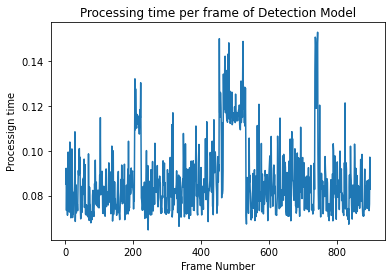

In [20]:
x = Predict_detection["frame_number"]
y = Predict_detection["processing_time"]

import matplotlib.pyplot as plt
plt.plot(x,y)
plt.title('Processing time per frame of Detection Model')
plt.xlabel('Frame Number')
plt.ylabel('Processign time')
plt.show()

Graph of the object detection when classification is also run

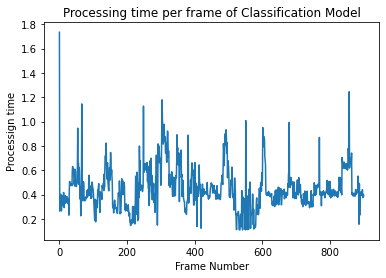

In [21]:
x = Predicted["frame_number"]
y = Predicted["processing_time"]
plt.plot(x,y)
plt.title('Processing time per frame of Classification Model')
plt.xlabel('Frame Number')
plt.ylabel('Processign time')
plt.show()

Implementing Producer Consumer Model:

In [22]:
class odetection(): ## Object detection using the producer consumer model

    def __init__(self):
        self.CONFIDENCE= 0.5
        self.SCORE_THRESHOLD = 0.5
        self.IOU_THRESHOLD = 0.5
        self.configPath= "darknet\cfg\yolov4-tiny.cfg"
        self.weightsPath= "yolov4-tiny.weights"
        self.font_scale=1
        self.thickness = 1

    def loadTinyYOLO(self):
        
        self.labels = open("coco.names").read().strip().split("\n")
        self.colors = np.random.randint(0, 255, size=(len(self.labels), 3), dtype="uint8")
        self.net = cv2.dnn.readNetFromDarknet(self.configPath, self.weightsPath)
        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        return ln
    
    def Run_detection(self,ln,model,image,check_car_type):

        car_counter=[]
        ht, wt = image.shape[:2]
    
        sedan_counter=[]
        suv_counter=[]
        frame_counter=[]
        frame_number=0
        processing_time=[]

        h, w = image.shape[:2]
        blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
        self.net.setInput(blob)
        start = time.perf_counter()
        output_layer = self.net.forward(ln)
                
        boxes, confidences, class_ids = [], [], []
        for output in output_layer:
            for detection in output:

                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                # discard weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > self.CONFIDENCE:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[:4] * np.array([w, h, w, h])
                    (centerX, centerY, width, height) = box.astype("int")

                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                #setting bounding box co-ordinates
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)                
            # perform the non maximum suppression given the scores defined before
        detection = cv2.dnn.NMSBoxes(boxes, confidences, self.SCORE_THRESHOLD, self.IOU_THRESHOLD)
        
        font_scale = 1
        thickness = 1
        sedan=0
        suv=0
        car_per_frame=0
        # ensure at least one detection exists
        if len(detection) > 0: #[4]
            # loop over the indexes we are keeping
            for i in detection.flatten():
            # extract the bounding box coordinates
                x, y = boxes[i][0], boxes[i][1]
                w, h = boxes[i][2], boxes[i][3]
            # draw a bounding box rectangle and label on the image
                color = [int(c) for c in self.colors[class_ids[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness) 
                text = f"{self.labels[class_ids[i]]}: {confidences[i]:.2f}"
                if (self.labels[class_ids[i]== "car"]):
                    car_per_frame += 1
                    
                    if (check_car_type==1):
                        
                        cropped_img = image[y:y+h, x:x+w]
                        cropped_img=cropped_img/255
                        try:
                            
                            cropped_img = cv2.resize(cropped_img,(224,224),cv2.INTER_AREA)
                            class_name= object_classification.Predict(self,model,cropped_img)
                            if (class_name[0]=="sedan"):
                                
                                sedan +=1
                                text1=f"Sedan: {confidences[i]:.2f}"

                            else:
                                suv +=1
                                text1=f"SUV: {confidences[i]:.2f}"

                        except:
                            break
                    else:
                        text1= f"car: {confidences[i]:.2f}"
                # calculate text width & height to draw the transparent boxes as background of the text
                (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
                text_offset_x = x
                text_offset_y = y - 5
                box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
                overlay = image.copy()
                
                cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
            
            # add opacity (transparency to the box)
                image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
            # now put the text (label: confidence %)
                cv2.putText(image, text1, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
        time_took = time.perf_counter() - start
        processing_time.append(time_took)
                #elapse time is the time to identify an object in the video and classify it if required
        elapse_time = time.perf_counter() - start

        if (check_car_type==1):
            
            annotation = "Total suv: "+str(suv)+"\nTotal sedan: "+str(sedan)+"\nTotal cars: "+str(sedan+suv) #+ "\nElapse time: "+str(fps)+" fps"
        else:

            annotation = "Total cars: "+str(car_per_frame)#+ "\nElapse time: "+str(fps)+" fps"
        y0, dy = 50, 20
        for i, line in enumerate(annotation.split('\n')):
            y = y0 + i*dy
            cv2.putText(image, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 0), 1)

        
        return image
              
    


In [23]:
from threading import Thread
import time
import random
from queue import Queue

queue = Queue(30)
#start timer here
video_file = "assignment-clip.mp4"
cap = cv2.VideoCapture(video_file)
start_model = time.perf_counter()

ht = cap.get(3)
wt = cap.get(4)
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter('consumer_video.mp4',cv2.VideoWriter_fourcc(*'MP4V'),30, (428,576))
# objClass = oclassification()
# X_test_scaled,y_test,model=objClass.TrainClassifier()
obj1 = odetection()
ln = obj1.loadTinyYOLO()



In [24]:
class ProducerThread(Thread): #Creating frames and adding to queue
    def run(self):
        nums = range(5)
        global queue
        while True:
#             print("Running producer")
            ret, image = cap.read()
            if ret == False:
                break
            queue.put(image)
            
class ConsumerThread(Thread): #Running consumer for object Classification
    def run(self):
        global queue
        frame_count=0
        while True:
#             print("running consumer")
            img = queue.get() #getting image frame from queue
            img_returned = obj1.Run_detection(ln,model,img,1) #calling detection function
            frame_count+=1
            
            #stop timer here 
            out.write(img_returned)
            print(f"frame_count {frame_count}")
            if(frame_count==900):
                total_time = time.perf_counter() - start_model
                
                out.release()
                print(f"Throughput of the model is {900/total_time} frames/sec")

print("Running object classification using producer consumer model\n")
ProducerThread().start()
ConsumerThread().start()

Running object classification using producer consumer model

frame_count 1
frame_count 2
frame_count 3
frame_count 4
frame_count 5
frame_count 6
frame_count 7
frame_count 8
frame_count 9
frame_count 10
frame_count 11
frame_count 12
frame_count 13
frame_count 14
frame_count 15
frame_count 16
frame_count 17
frame_count 18
frame_count 19
frame_count 20
frame_count 21
frame_count 22
frame_count 23
frame_count 24
frame_count 25
frame_count 26
frame_count 27
frame_count 28
frame_count 29
frame_count 30
frame_count 31
frame_count 32
frame_count 33
frame_count 34
frame_count 35
frame_count 36
frame_count 37
frame_count 38
frame_count 39
frame_count 40
frame_count 41
frame_count 42
frame_count 43
frame_count 44
frame_count 45
frame_count 46
frame_count 47
frame_count 48
frame_count 49
frame_count 50
frame_count 51
frame_count 52
frame_count 53
frame_count 54
frame_count 55
frame_count 56
frame_count 57
frame_count 58
frame_count 59
frame_count 60
frame_count 61
frame_count 62
frame_count 63
fra

frame_count 516
frame_count 517
frame_count 518
frame_count 519
frame_count 520
frame_count 521
frame_count 522
frame_count 523
frame_count 524
frame_count 525
frame_count 526
frame_count 527
frame_count 528
frame_count 529
frame_count 530
frame_count 531
frame_count 532
frame_count 533
frame_count 534
frame_count 535
frame_count 536
frame_count 537
frame_count 538
frame_count 539
frame_count 540
frame_count 541
frame_count 542
frame_count 543
frame_count 544
frame_count 545
frame_count 546
frame_count 547
frame_count 548
frame_count 549
frame_count 550
frame_count 551
frame_count 552
frame_count 553
frame_count 554
frame_count 555
frame_count 556
frame_count 557
frame_count 558
frame_count 559
frame_count 560
frame_count 561
frame_count 562
frame_count 563
frame_count 564
frame_count 565
frame_count 566
frame_count 567
frame_count 568
frame_count 569
frame_count 570
frame_count 571
frame_count 572
frame_count 573
frame_count 574
frame_count 575
frame_count 576
frame_count 577
frame_co

## References

<br>[1] Object Detection using YOLO: https://www.thepythoncode.com/code/yolo-object-detection-with-opencv-and-pytorch-in-python
<br>[2] Download bulk Images: https://github.com/ostrolucky/Bulk-Bing-Image-downloader
<br>[3] TransferLearning using Keras: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/cnn_transfer_learning.ipynb
<br>[4] Object Detection using YOLO & OpenCV: https://www.mygreatlearning.com/blog/yolo-object-detection-using-opencv/
<br> [5] Implementation of producer consumer model https://www.agiliq.com/blog/2013/10/producer-consumer-problem-in-python/#:~:text=The%20problem%20describes%20two%20processes,adds%20it%20to%20the%20queue.


